In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn import preprocessing, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [3]:
income_statement = pd.read_csv('Data\Fundamentals\income-statement.csv')
balance_sheet = pd.read_csv('Data\Fundamentals\\balance-sheet-statement.csv')
cashflow_statement = pd.read_csv('Data\Fundamentals\cash-flow-statement.csv')
key_metrics = pd.read_csv('Data\Fundamentals\key_metrics.csv')

In [4]:
income_statement.head()

,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Ticker
0,2019-09-30,2.682700e+10,-0.001154,0.0,0.0,0.0,0.0,1.901000e+09,5.340000e+09,1.167000e+09,4.063000e+09,7.750000e+08,0.0,0.0,3.217000e+09,0.0,3.217000e+09,0.71,0.70,4.544000e+09,4.606000e+09,0.207338,0.0,0.337608,0.199053,0.119917,0.099899,9.057000e+09,5.340000e+09,3.217000e+09,0.151452,0.119917,CMCSA
1,2019-06-30,2.685800e+10,-0.000037,0.0,0.0,0.0,0.0,1.885000e+09,5.356000e+09,1.137000e+09,4.164000e+09,9.610000e+08,0.0,0.0,3.125000e+09,0.0,3.125000e+09,0.69,0.68,4.540000e+09,4.600000e+09,0.207391,0.0,0.360191,0.199419,0.116353,0.177861,9.674000e+09,5.356000e+09,3.125000e+09,0.155038,0.116353,CMCSA
2,2019-03-31,2.685900e+10,-0.035445,0.0,0.0,0.0,0.0,1.888000e+09,5.182000e+09,1.150000e+09,4.708000e+09,1.076000e+09,0.0,0.0,3.553000e+09,0.0,3.553000e+09,0.78,0.77,4.534000e+09,4.594000e+09,0.189160,0.0,0.316542,0.192933,0.132283,0.191333,8.502000e+09,5.182000e+09,3.553000e+09,0.175286,0.132283,CMCSA
3,2018-12-31,2.784600e+10,0.258008,0.0,0.0,0.0,0.0,2.112000e+09,4.514000e+09,1.129000e+09,3.068000e+09,4.860000e+08,0.0,0.0,2.511000e+09,0.0,2.511000e+09,0.56,0.55,4.584000e+09,4.640000e+09,0.186422,0.0,0.276916,0.162106,0.090175,0.094197,7.711000e+09,4.514000e+09,2.511000e+09,0.110177,0.090175,CMCSA
4,2018-09-30,2.213500e+10,0.018403,0.0,0.0,0.0,0.0,1.667000e+09,4.836000e+09,8.300000e+08,3.895000e+09,9.990000e+08,0.0,0.0,2.886000e+09,0.0,2.886000e+09,0.63,0.62,4.599000e+09,4.655000e+09,0.187111,0.0,0.095369,0.218478,0.130382,0.162006,2.111000e+09,4.836000e+09,2.886000e+09,0.175966,0.130382,CMCSA


In [5]:
balance_sheet.head()

,date,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Ticker
0,2019-09-30,3.507000e+09,1.710000e+09,5.217000e+09,1.068400e+10,0.0,2.232300e+10,4.679000e+10,8.001300e+10,7.473000e+09,0.000000e+00,2.340510e+11,2.563740e+11,1.019800e+10,1.039000e+09,2.598900e+10,9.984700e+10,1.008860e+11,2.944000e+09,0.000000e+00,0.0,1.453550e+11,1.782300e+11,3.067900e+10,4.857000e+10,7.814400e+10,9.183000e+09,9.737900e+10,0.0,6.886000e+09,CMCSA
1,2019-06-30,3.919000e+09,1.718000e+09,5.637000e+09,1.083500e+10,0.0,2.136100e+10,4.604700e+10,8.127700e+10,8.438000e+09,0.000000e+00,2.351940e+11,2.565550e+11,1.001400e+10,6.365000e+09,3.100800e+10,1.012480e+11,1.076130e+11,2.642000e+09,0.000000e+00,0.0,1.472760e+11,1.797050e+11,3.043300e+10,4.642500e+10,7.685000e+10,1.015600e+10,1.036940e+11,0.0,1.421000e+09,CMCSA
2,2019-03-31,3.498000e+09,8.600000e+07,3.584000e+09,1.073600e+10,0.0,2.027300e+10,4.572100e+10,8.160500e+10,9.159000e+09,0.000000e+00,2.359160e+11,2.561890e+11,1.023200e+10,4.629000e+09,2.791700e+10,1.044640e+11,1.090930e+11,2.485000e+09,0.000000e+00,0.0,1.518800e+11,1.812300e+11,3.010400e+10,4.437900e+10,7.495900e+10,9.245000e+09,1.055950e+11,0.0,1.433000e+09,CMCSA
3,2018-12-31,3.814000e+09,9.400000e+07,3.908000e+09,1.110400e+10,0.0,2.184800e+10,4.443700e+10,7.982000e+10,7.883000e+09,3.950000e+09,2.298360e+11,2.516840e+11,8.494000e+09,4.398000e+09,2.760300e+10,1.073450e+11,1.117430e+11,2.182000e+09,1.543000e+09,0.0,1.509130e+11,1.800710e+11,2.994400e+10,4.198300e+10,7.161300e+10,7.977000e+09,1.079290e+11,0.0,1.555000e+09,CMCSA
4,2018-09-30,1.061600e+10,8.700000e+07,1.070300e+10,8.983000e+09,0.0,2.320600e+10,3.985500e+10,5.053200e+10,7.724000e+09,0.000000e+00,1.774290e+11,2.006350e+11,7.036000e+09,3.173000e+09,1.962700e+10,6.971100e+10,7.288400e+10,1.633000e+09,0.000000e+00,0.0,1.079180e+11,1.291120e+11,2.987700e+10,4.121800e+10,7.152300e+10,7.811000e+09,6.226800e+10,0.0,1.567000e+09,CMCSA


In [6]:
cashflow_statement.head()

,date,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,Ticker
0,2019-09-30,3.717000e+09,257000000.0,5.191000e+09,3.119000e+09,-6.700000e+07,-1.740000e+08,-3.498000e+09,-5.332000e+09,-8.200000e+07,-955000000.0,-2.094000e+09,-16000000.0,-4.170000e+08,2.072000e+09,0.0,CMCSA
1,2019-06-30,4.318000e+09,288000000.0,7.040000e+09,2.794000e+09,-6.600000e+07,-1.269000e+09,-4.188000e+09,-2.543000e+09,-1.030000e+08,-954000000.0,-2.407000e+09,-23000000.0,4.220000e+08,4.246000e+09,0.0,CMCSA
2,2019-03-31,3.320000e+09,245000000.0,7.231000e+09,2.639000e+09,-4.800000e+07,-6.860000e+08,-3.226000e+09,-8.120000e+08,-2.470000e+08,-869000000.0,-4.325000e+09,8000000.0,-3.120000e+08,4.592000e+09,0.0,CMCSA
3,2018-12-31,3.197000e+09,219000000.0,5.790000e+09,3.727000e+09,-3.813100e+10,-1.455000e+09,-4.226400e+10,-1.863000e+09,-1.038000e+09,-865000000.0,2.600600e+10,-245000000.0,-1.071300e+10,2.063000e+09,0.0,CMCSA
4,2018-09-30,-2.725000e+09,197000000.0,5.970000e+09,2.829000e+09,0.000000e+00,-1.586000e+09,-3.284000e+09,-2.944000e+09,-1.284000e+09,-871000000.0,6.094000e+09,0.0,8.780000e+09,3.141000e+09,0.0,CMCSA


In [7]:
key_metrics.head()

,date,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Capex per Share,Ticker
0,2019-09-30,5.903829,0.707967,1.142386,0.589789,0.771787,17.197183,38.811840,17.197183,22.458847,1.993907e+11,2.967697e+11,61.980329,7.432464,38.410850,74.399522,2.551581,2.551581,11.062352,32.766890,57.170048,110.734970,0.016134,0.013441,2.280789,0.695195,10.751794,0.858940,4.575835,1.613615,0.004790,0.296860,0.0,0.0,0.312095,2.067304,10.683791,1.480287,0.009580,16.551078,-36.311620,-3.666000e+09,-1.869000e+09,-1.559070e+11,1.680300e+11,1.075950e+10,1.010600e+10,0.0,0.552597,CMCSA
1,2019-06-30,5.915859,0.688326,1.550661,1.052203,0.863216,16.927313,38.607489,16.927313,23.953744,1.861400e+11,2.898340e+11,59.564800,6.930523,26.440341,38.965878,2.422121,2.422121,10.791347,29.960099,41.169602,60.672807,0.016788,0.025663,2.338386,0.700454,10.718834,0.688887,4.710642,2.252800,0.005125,0.305280,0.0,0.0,0.316801,3.110915,11.868316,1.908087,0.010723,16.191324,-36.551046,-9.647000e+09,-4.427000e+09,-1.583440e+11,1.639080e+11,1.083500e+10,1.001400e+10,0.0,0.498458,CMCSA
2,2019-03-31,5.923908,0.783635,1.594839,1.133436,0.771504,16.532642,38.505514,16.532642,24.314733,1.772794e+11,2.828744e+11,49.895694,6.600372,24.516581,34.496867,2.365018,2.365018,10.531829,33.271513,39.119679,55.044639,0.020042,0.028988,2.417722,0.707407,12.420019,0.726188,4.506087,2.035182,0.004902,0.244582,0.0,0.0,0.318534,3.456501,12.838910,1.586998,0.009122,17.073369,-37.404940,-7.644000e+09,-6.646000e+09,-1.609570e+11,1.665850e+11,1.078550e+10,1.012300e+10,0.0,0.461403,CMCSA
3,2018-12-31,6.074607,0.547775,1.263089,0.572208,0.832024,15.622382,37.492147,15.622382,24.623037,1.794636e+11,2.873926e+11,71.470968,6.444861,30.995440,68.419215,2.506020,2.506020,10.320786,37.270471,49.636028,109.566374,0.013992,0.014616,2.514502,0.715465,13.996758,0.791508,3.998229,2.305854,0.004820,0.344484,0.0,0.0,0.317144,1.828229,8.792548,1.009473,0.007865,13.876053,-36.613220,-5.755000e+09,-8.207000e+09,-1.582230e+11,1.643870e+11,1.096950e+10,9.254000e+09,0.0,0.690881,CMCSA
4,2018-09-30,4.813003,0.627528,1.298108,0.779735,2.308328,15.551859,32.638182,15.551859,16.028267,1.701170e+11,2.323850e+11,58.945603,7.685431,28.495312,47.439211,2.378494,2.378494,10.498532,110.082904,38.925462,64.803405,0.016965,0.021080,1.805182,0.643517,29.496921,1.182351,5.826506,2.068607,0.005120,0.301802,0.0,0.0,0.251860,2.504195,9.284815,-1.143037,0.008900,14.818317,-24.281746,3.579000e+09,2.099100e+10,-1.059060e+11,1.273360e+11,9.909000e+09,8.525000e+09,0.0,0.518374,CMCSA


In [8]:
# merge available data

consol = income_statement.merge(balance_sheet, on=['date','Ticker'], how='left')
consol = consol.merge(cashflow_statement, on=['date','Ticker'], how='left')
consol = consol.merge(key_metrics, on=['date','Ticker'], how='left')
consol.head()

,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Ticker,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Capex per Share
0,2019-09-30,2.682700e+10,-0.001154,0.0,0.0,0.0,0.0,1.901000e+09,5.340000e+09,1.167000e+09,4.063000e+09,7.750000e+08,0.0,0.0,3.217000e+09,0.0,3.217000e+09,0.71,0.70,4.544000e+09,4.606000e+09,0.207338,0.0,0.337608,0.199053,0.119917,0.099899,9.057000e+09,5.340000e+09,3.217000e+09,0.151452,0.119917,CMCSA,3.507000e+09,1.710000e+09,5.217000e+09,1.068400e+10,0.0,2.232300e+10,4.679000e+10,8.001300e+10,7.473000e+09,0.000000e+00,2.340510e+11,2.563740e+11,1.019800e+10,1.039000e+09,2.598900e+10,9.984700e+10,1.008860e+11,2.944000e+09,0.000000e+00,0.0,1.453550e+11,1.782300e+11,3.067900e+10,4.857000e+10,7.814400e+10,9.183000e+09,9.737900e+10,0.0,6.886000e+09,3.717000e+09,257000000.0,5.191000e+09,3.119000e+09,-6.700000e+07,-1.740000e+08,-3.498000e+09,-5.332000e+09,-8.200000e+07,-955000000.0,-2.094000e+09,-16000000.0,-4.170000e+08,2.072000e+09,0.0,5.903829,0.707967,1.142386,0.589789,0.771787,17.197183,38.811840,17.197183,22.458847,1.993907e+11,2.967697e+11,61.980329,7.432464,38.410850,74.399522,2.551581,2.551581,11.062352,32.766890,57.170048,110.734970,0.016134,0.013441,2.280789,0.695195,10.751794,0.858940,4.575835,1.613615,0.004790,0.296860,0.0,0.0,0.312095,2.067304,10.683791,1.480287,0.009580,16.551078,-36.311620,-3.666000e+09,-1.869000e+09,-1.559070e+11,1.680300e+11,1.075950e+10,1.010600e+10,0.0,0.552597
1,2019-06-30,2.685800e+10,-0.000037,0.0,0.0,0.0,0.0,1.885000e+09,5.356000e+09,1.137000e+09,4.164000e+09,9.610000e+08,0.0,0.0,3.125000e+09,0.0,3.125000e+09,0.69,0.68,4.540000e+09,4.600000e+09,0.207391,0.0,0.360191,0.199419,0.116353,0.177861,9.674000e+09,5.356000e+09,3.125000e+09,0.155038,0.116353,CMCSA,3.919000e

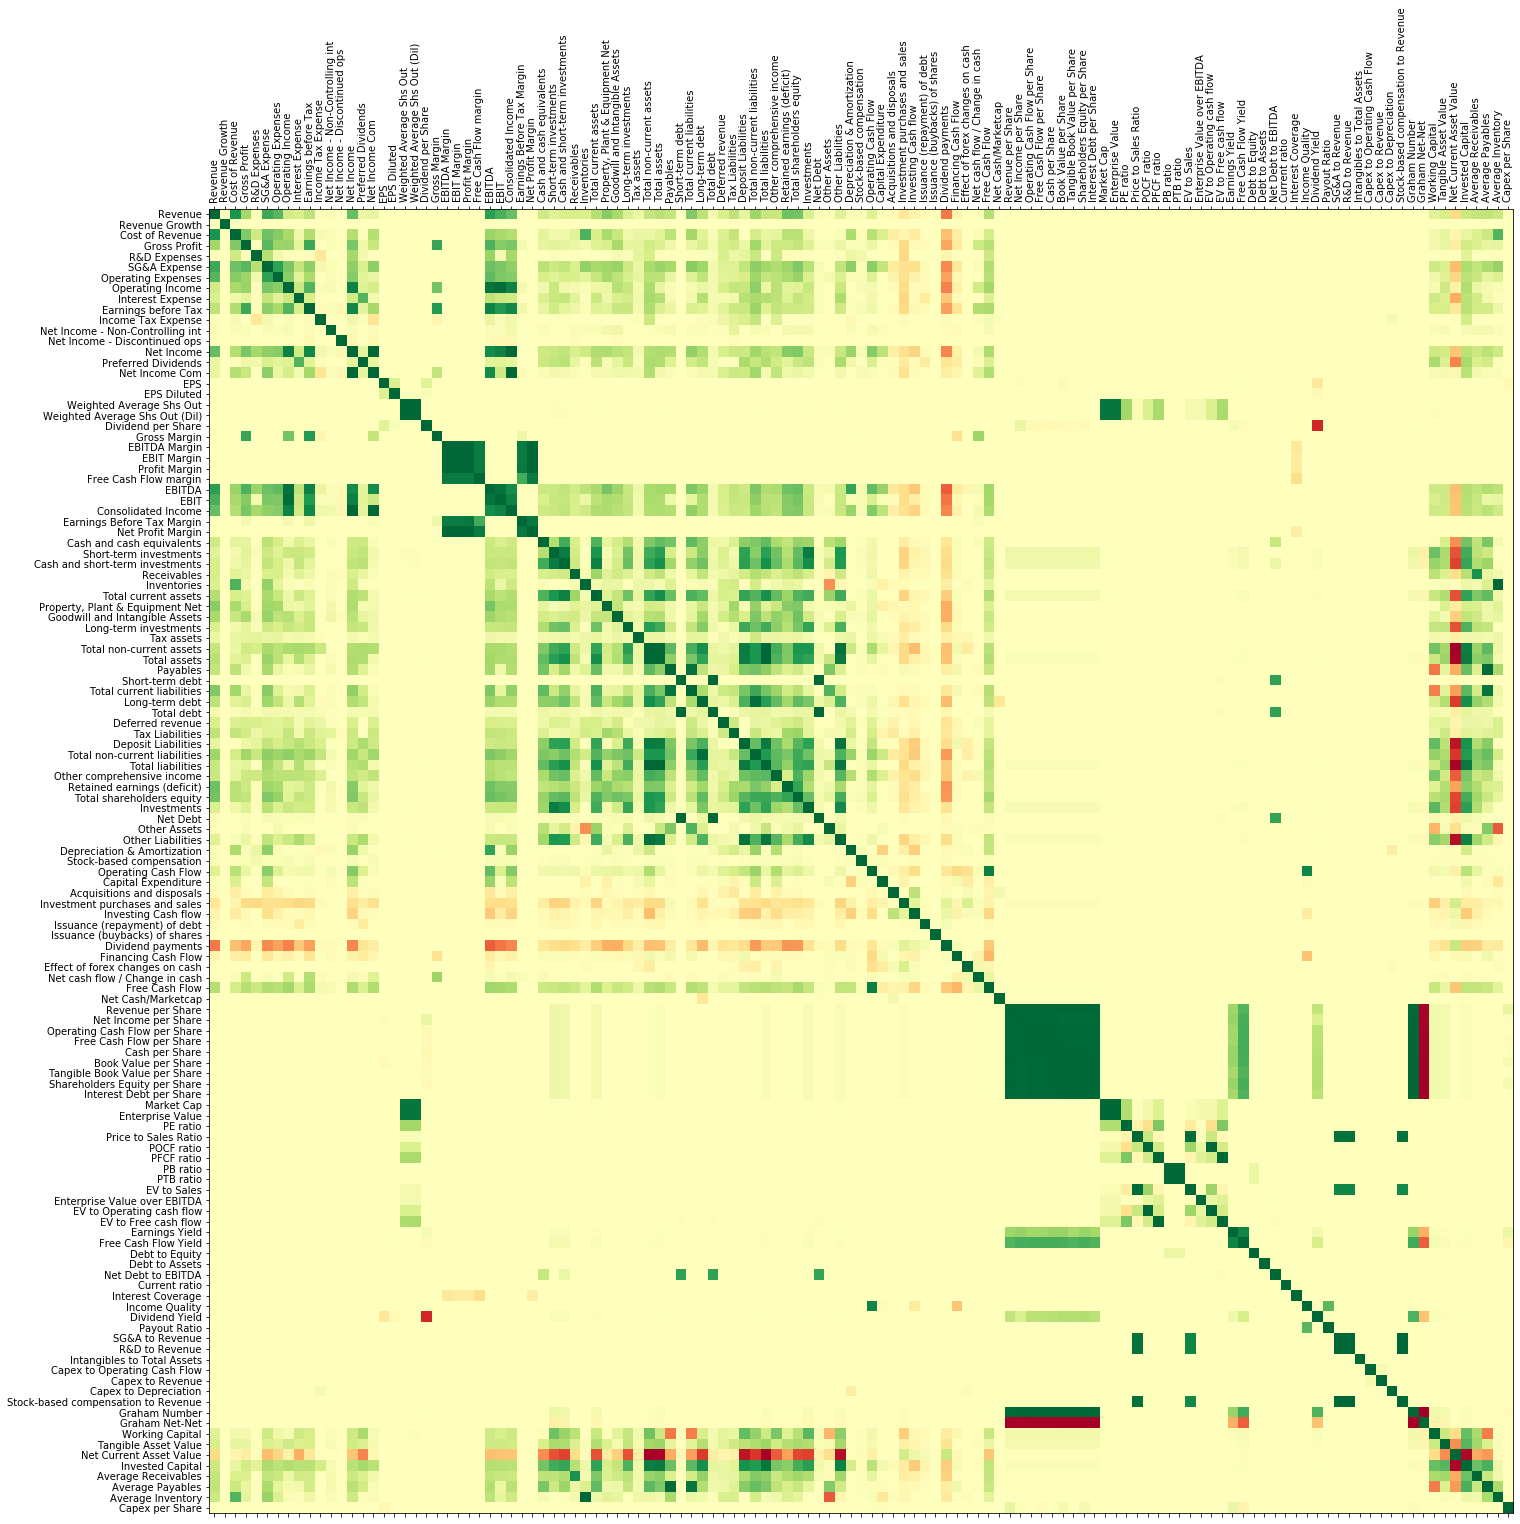

In [9]:
# visualize correlation between features

consol_corr = consol.corr()

labels = [c for c in consol_corr.columns]

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111)

ax.matshow(consol_corr, cmap=plt.cm.RdYlGn)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(rotation=90)

plt.show()

In [10]:
# # select the most important features

# X = np.array(consol_filtered.drop(['Invest', 'Ticker'], 1))
# y = np.array(consol_filtered['Invest'])

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# clf = DecisionTreeClassifier(random_state=15, criterion='entropy', max_depth=10)
# clf.fit(X,y)

# fi_col = []
# fi = []

# for i,column in enumerate(consol_filtered.drop(['Invest', 'Ticker'], 1)):
#     fi_col.append(column)
#     fi.append(clf.feature_importances_[i])
    
# fi_zip = zip(fi_col, fi)
# fi_df = pd.DataFrame(fi_zip, columns=['Feature','Feature Importance'])
# fi_df = fi_df.sort_values('Feature Importance', ascending=False)
# fi_df['Feature'].tolist()[:60]

In [11]:
# select features defined above

consol_filtered = consol.copy()[['Dividend Yield',
 'Book Value per Share',
 'SG&A Expense',
 'Earnings Yield',
 'R&D Expenses',
 'Free Cash Flow Yield',
 'Goodwill and Intangible Assets',
 'Cash per Share',
 'Capex to Revenue',
 'Depreciation & Amortization',
 'Free Cash Flow',
 'Average Receivables',
 'Dividend payments',
 'Tax Liabilities',
 'Working Capital',
 'Free Cash Flow margin',
 'Tangible Asset Value',
 'Operating Cash Flow per Share',
 'Total non-current liabilities',
 'Net Debt to EBITDA',
 'Graham Number',
 'Inventories',
 'Other comprehensive income',
 'Earnings before Tax',
 'Total liabilities',
 'Capex per Share',
 'Operating Expenses',
 'Net Current Asset Value',
 'Debt to Assets',
 'Retained earnings (deficit)',
 'Issuance (buybacks) of shares',
 'Other Liabilities',
 'Payables',
 'Average Inventory',
 'Financing Cash Flow',
 'EBIT',
 'Capital Expenditure',
 'Revenue per Share',
 'Investment purchases and sales',
 'Income Tax Expense',
 'Graham Net-Net',
 'Tangible Book Value per Share',
 'Short-term debt',
 'Long-term investments',
 'Profit Margin',
 'Interest Debt per Share',
 'Intangibles to Total Assets',
 'Net Cash/Marketcap',
 'Receivables',
 'Long-term debt',
 'Total non-current assets',
 'Free Cash Flow per Share',
 'Cash and cash equivalents',
 'Interest Expense',
 'Average Payables',
 'Other Assets',
 'Net Income per Share',
 'EBITDA',
 'Short-term investments',
 'Deferred revenue',
 'Current ratio',
 'Net Debt',
 'Total current assets',
 'Total current liabilities',
 'Net Income',
 'Total shareholders equity',
 'Operating Income',
 'Revenue',
 'date',
 'Ticker',
 'Market Cap']]

In [12]:
# filter on companies with a market cap larger than 500mil
# consider getting only sp500 stocks for this
# fill current ratio missing values and add ROE, Operating margin to features

consol_filtered = consol_filtered[consol_filtered['Market Cap']>500000000]

consol_filtered['Current ratio'] = np.where(consol_filtered['Current ratio'].isna(),
                                            consol_filtered['Total current assets']/consol_filtered['Total current liabilities'],
                                            consol_filtered['Current ratio'])
consol_filtered['ROE'] = consol_filtered['Net Income'] / consol_filtered['Total shareholders equity']
# consol_filtered['ROA'] = consol_filtered['Net Income'] / consol_filtered['Total assets']
consol_filtered['Operating margin'] = consol_filtered['Operating Income'] / consol_filtered['Revenue']  

consol_filtered.drop(columns=['Operating Income', 'Total shareholders equity', 'Net Income',
                              'Total current liabilities', 'Total current assets', 'Revenue'], inplace = True)

consol_filtered = consol_filtered.dropna()

In [13]:
# separate predict data and create future date
# correct the dates that fell on weekends and holidays

consol_filtered['date'] = pd.to_datetime(consol_filtered['date'])

consol_predict = consol_filtered[consol_filtered['date']>'2019-08-01 00:00:00']
consol_predict = consol_predict.replace([np.inf, -np.inf], np.nan)
consol_predict = consol_predict.dropna()
consol_predict = consol_predict[consol_predict['Market Cap']>500000000]

consol_filtered = consol_filtered[consol_filtered['date']<'2019-04-01 00:00:00']

US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())
consol_filtered['date']  = consol_filtered['date']  - 2 * US_BUSINESS_DAY

consol_filtered['1 year in future'] = consol_filtered['date'] + pd.Timedelta('365 days')
consol_filtered['1 year in future']  = consol_filtered['1 year in future']  - 2 * US_BUSINESS_DAY
consol_filtered.head()

C:\Users\kompogat\AppData\Local\Continuum\miniconda3\envs\data37\lib\site-packages\pandas\core\arrays\datetimes.py:837: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


,Dividend Yield,Book Value per Share,SG&A Expense,Earnings Yield,R&D Expenses,Free Cash Flow Yield,Goodwill and Intangible Assets,Cash per Share,Capex to Revenue,Depreciation & Amortization,Free Cash Flow,Average Receivables,Dividend payments,Tax Liabilities,Working Capital,Free Cash Flow margin,Tangible Asset Value,Operating Cash Flow per Share,Total non-current liabilities,Net Debt to EBITDA,Graham Number,Inventories,Other comprehensive income,Earnings before Tax,Total liabilities,Capex per Share,Operating Expenses,Net Current Asset Value,Debt to Assets,Retained earnings (deficit),Issuance (buybacks) of shares,Other Liabilities,Payables,Average Inventory,Financing Cash Flow,EBIT,Capital Expenditure,Revenue per Share,Investment purchases and sales,Income Tax Expense,Graham Net-Net,Tangible Book Value per Share,Short-term debt,Long-term investments,Profit Margin,Interest Debt per Share,Intangibles to Total Assets,Net Cash/Marketcap,Receivables,Long-term debt,Total non-current assets,Free Cash Flow per Share,Cash and cash equivalents,Interest Expense,Average Payables,Other Assets,Net Income per Share,EBITDA,Short-term investments,Deferred revenue,Current ratio,Net Debt,date,Ticker,Market Cap,ROE,Operating margin,1 year in future
2,0.004902,16.532642,0.0,0.020042,0.0,0.028988,8.160500e+10,0.771504,12.838910,3.320000e+09,4.592000e+09,1.078550e+10,-869000000.0,0.000000e+00,-7.644000e+09,0.191333,-6.646000e+09,1.594839,1.518800e+11,12.420019,17.073369,0.0,3.010400e+10,4.708000e+09,1.812300e+11,0.461403,1.888000e+09,-1.609570e+11,0.707407,4.437900e+10,-2.470000e+08,1.433000e+09,1.023200e+10,0.0,-4.325000e+09,5.182000e+09,2.639000e+09,5.923908,-6.860000e+08,1.076000e+09,-37.404940,38.505514,4.629000e+09,9.159000e+09,0.132283,24.314733,0.318534,0.0,1.073600e+10,1.044640e+11,2.359160e+11,1.133436,3.498000e+09,1.150000e+09,1.012300e+10,0.0,0.783635,8.502000e+09,86000000.0,2.485000e+09,0.726188,1.055950e+11,2019-03-28,CMCSA,1.772794e+11,0.047399,0.192933,2020-03-25
3,0.004820,15.622382,0.0,0.013992,0.0,0.014616,7.982000e+10,0.832024,8.792548,3.197000e+09,2.063000e+09,1.096950e+10,-865000000.0,1.543000e+09,-5.755000e+09,0.094197,-8.207000e+09,1.263089,1.509130e+11,13.996758,13.876053,0.0,2.994400e+10,3.068000e+09,1.800710e+11,0.690881,2.112000e+09,-1.582230e+11,0.715465,4.198300e+10,-1.038000e+09,1.555000e+09,8.494000e+09,0.0,2.600600e+10,4.514000e+09,3.727000e+09,6.074607,-1.455000e+09,4.860000e+08,-36.613220,37.492147,4.398000e+09,7.883000e+09,0.090175,24.623037,0.317144,0.0,1.110400e+10,1.073450e+11,2.298360e+11,0.572208,3.814000e+09,1.129000e+09,9.254000e+09,0.0,0.547775,7.711000e+09,94000000.0,2.182000e+09,0.791508,1.079290e+11,2018-12-27,CMCSA,1.794636e+11,0.035063,0.162106,2019-12-24
4,0.005120,15.551859,0.0,0.016965,0.0,0.021080,5.053200e+10,2.308328,9.284815,-2.725000e+09,3.141000e+09,9.909000e+09,-871000000.0,0.000000e+00,3.579000e+09,0.162006,2.099100e+10,1.298108,1.079180e+11,29.496921,14.818317,0.0,2.987700e+10,3.895000e+09,1.291120e+11,0.518374,1.667000e+09,-1.059060e+11,0.643517,4.121800e+10,-1.284000e+09,1.567000e+09,7.036000e+09,0.0,6.094000e+09,4.836000e+09,2.829000e+09,4.813003,-1.586000e+09,9.990000e+08,-24.281746,32.638182,3.173000e+09,7.724000e+09,0.130382,16.028267,0.251860,0.0,8.983000e+09,6.971100e+10,1.774290e+11,0.779735,1.061600e+10,8.300000e+08,8.525000e+09,0.0,0.627528,2.111000e+09,87000000.0,1.633000e+09,1.182351,6.226800e+10,2018-09-27,CMCSA,1.701170e+11,0.040351,0.218478,2019-09-25
5,0.006100,15.314991,0.0,0.022345,0.0,0.033441,5.090800e+10,1.240468,9.660000,7.605000e+09,4.302000e+09,9.841000e+09,-878000000.0,0.000000e+00,-7.920000e+08,0.221440,1.978600e+10,1.530113,9.968500e+10,4.663919,15.494400,0.0,2.991000e+10,4.285000e+09,1.205540e+11,0.487435,1.653000e+09,-1.023390e+11,0.630354,4.026900e+10,-1.269000e+09,1.862000e+09,6.940000e+09,0.0,-4.384000e+09,5.014000e+09,2.761000e+09,4.708622,-1.587000e+09,1.077000e+09,-23.420873,30.402946,2.634000e+09,7.438000e+09,0.147964,14.165078,0.266188,0.0,8.847000e+09,6

In [14]:
# read in historical prices for stocks and sp500

historical_price = pd.read_csv('Data/Price Data/historical_price.csv', usecols=['Ticker', 'adjClose', 'date'])
sp500 = pd.read_csv('Data/Price Data/^GSPC.csv', usecols=['Date', 'Adj Close'])

In [15]:
# pull in the historical price data twice
# once for the date results were published and once 1 year in the future

historical_price['date'] = pd.to_datetime(historical_price['date'])
sp500['Date'] = pd.to_datetime(sp500['Date'])

consol_filtered = consol_filtered.merge(historical_price, on=['date','Ticker'], how='left')
consol_filtered = consol_filtered.merge(historical_price, left_on=['1 year in future','Ticker'], right_on=['date','Ticker'], how='left')
consol_filtered.drop(columns=['date_y'], inplace=True)
consol_filtered = consol_filtered.rename(columns={'adjClose_x':'CurrentPrice','adjClose_y':'FuturePrice'})

consol_filtered = consol_filtered.merge(sp500, left_on='date_x', right_on='Date', how='left')
consol_filtered = consol_filtered.merge(sp500, left_on='1 year in future', right_on='Date', how='left')
consol_filtered.drop(columns=['Date_x','Date_y'], inplace=True)
consol_filtered = consol_filtered.rename(columns={'Adj Close_x':'sp500_Current','Adj Close_y':'sp500_Future'})
consol_filtered.head()

,Dividend Yield,Book Value per Share,SG&A Expense,Earnings Yield,R&D Expenses,Free Cash Flow Yield,Goodwill and Intangible Assets,Cash per Share,Capex to Revenue,Depreciation & Amortization,Free Cash Flow,Average Receivables,Dividend payments,Tax Liabilities,Working Capital,Free Cash Flow margin,Tangible Asset Value,Operating Cash Flow per Share,Total non-current liabilities,Net Debt to EBITDA,Graham Number,Inventories,Other comprehensive income,Earnings before Tax,Total liabilities,Capex per Share,Operating Expenses,Net Current Asset Value,Debt to Assets,Retained earnings (deficit),Issuance (buybacks) of shares,Other Liabilities,Payables,Average Inventory,Financing Cash Flow,EBIT,Capital Expenditure,Revenue per Share,Investment purchases and sales,Income Tax Expense,Graham Net-Net,Tangible Book Value per Share,Short-term debt,Long-term investments,Profit Margin,Interest Debt per Share,Intangibles to Total Assets,Net Cash/Marketcap,Receivables,Long-term debt,Total non-current assets,Free Cash Flow per Share,Cash and cash equivalents,Interest Expense,Average Payables,Other Assets,Net Income per Share,EBITDA,Short-term investments,Deferred revenue,Current ratio,Net Debt,date_x,Ticker,Market Cap,ROE,Operating margin,1 year in future,CurrentPrice,FuturePrice,sp500_Current,sp500_Future
0,0.004902,16.532642,0.0,0.020042,0.0,0.028988,8.160500e+10,0.771504,12.838910,3.320000e+09,4.592000e+09,1.078550e+10,-869000000.0,0.000000e+00,-7.644000e+09,0.191333,-6.646000e+09,1.594839,1.518800e+11,12.420019,17.073369,0.0,3.010400e+10,4.708000e+09,1.812300e+11,0.461403,1.888000e+09,-1.609570e+11,0.707407,4.437900e+10,-2.470000e+08,1.433000e+09,1.023200e+10,0.0,-4.325000e+09,5.182000e+09,2.639000e+09,5.923908,-6.860000e+08,1.076000e+09,-37.404940,38.505514,4.629000e+09,9.159000e+09,0.132283,24.314733,0.318534,0.0,1.073600e+10,1.044640e+11,2.359160e+11,1.133436,3.498000e+09,1.150000e+09,1.012300e+10,0.0,0.783635,8.502000e+09,86000000.0,2.485000e+09,0.726188,1.055950e+11,2019-03-28,CMCSA,1.772794e+11,0.047399,0.192933,2020-03-25,40.01,33.57,2815.439941,2475.560059
1,0.004820,15.622382,0.0,0.013992,0.0,0.014616,7.982000e+10,0.832024,8.792548,3.197000e+09,2.063000e+09,1.096950e+10,-865000000.0,1.543000e+09,-5.755000e+09,0.094197,-8.207000e+09,1.263089,1.509130e+11,13.996758,13.876053,0.0,2.994400e+10,3.068000e+09,1.800710e+11,0.690881,2.112000e+09,-1.582230e+11,0.715465,4.198300e+10,-1.038000e+09,1.555000e+09,8.494000e+09,0.0,2.600600e+10,4.514000e+09,3.727000e+09,6.074607,-1.455000e+09,4.860000e+08,-36.613220,37.492147,4.398000e+09,7.883000e+09,0.090175,24.623037,0.317144,0.0,1.110400e+10,1.073450e+11,2.298360e+11,0.572208,3.814000e+09,1.129000e+09,9.254000e+09,0.0,0.547775,7.711000e+09,94000000.0,2.182000e+09,0.791508,1.079290e+11,2018-12-27,CMCSA,1.794636e+11,0.035063,0.162106,2019-12-24,33.93,44.53,2488.830078,3223.379883
2,0.005120,15.551859,0.0,0.016965,0.0,0.021080,5.053200e+10,2.308328,9.284815,-2.725000e+09,3.141000e+09,9.909000e+09,-871000000.0,0.000000e+00,3.579000e+09,0.162006,2.099100e+10,1.298108,1.079180e+11,29.496921,14.818317,0.0,2.987700e+10,3.895000e+09,1.291120e+11,0.518374,1.667000e+09,-1.059060e+11,0.643517,4.121800e+10,-1.284000e+09,1.567000e+09,7.036000e+09,0.0,6.094000e+09,4.836000e+09,2.829000e+09,4.813003,-1.586000e+09,9.990000e+08,-24.281746,32.638182,3.173000e+09,7.724000e+09,0.130382,16.028267,0.251860,0.0,8.983000e+09,6.971100e+10,1.774290e+11,0.779735,1.061600e+10,8.300000e+08,8.525000e+09,0.0,0.627528,2.111000e+09,87000000.0,1.633000e+09,1.182351,6.226800e+10,2018-09-27,CMCSA,1.701170e+11,0.040351,0.218478,2019-09-25,34.49,45.83,2914.000000,2984.870117
3,0.006100,15.314991,0.0,0.022345,0.0,0.033441,5.090800e+10,1.240468,9.660000,7.605000e+09,4.302000e+09,9.841000e+09,-878000000.0,0.000000e+00,-7.920000e+08,0.221440,1.978600e+10,1.530113,9.968500e+10,4.663919,15.494400,0.0,2.991000e+10,4.285000e+09,1.205540e+11,0.487435,1.653000e+09,-1.023390e+11,0.630354,4.026900e+10,-1.269000e+09,1.862000e+09,6.940000e+09,0.0,-4.3840

In [16]:
consol_filtered.isna().sum()

Dividend Yield                       0
Book Value per Share                 0
SG&A Expense                         0
Earnings Yield                       0
R&D Expenses                         0
Free Cash Flow Yield                 0
Goodwill and Intangible Assets       0
Cash per Share                       0
Capex to Revenue                     0
Depreciation & Amortization          0
Free Cash Flow                       0
Average Receivables                  0
Dividend payments                    0
Tax Liabilities                      0
Working Capital                      0
Free Cash Flow margin                0
Tangible Asset Value                 0
Operating Cash Flow per Share        0
Total non-current liabilities        0
Net Debt to EBITDA                   0
Graham Number                        0
Inventories                          0
Other comprehensive income           0
Earnings before Tax                  0
Total liabilities                    0
Capex per Share          

In [17]:
# define labels as 'Invest' where 1 indicates that the stock has overperformed the sp500 
# by more than 25% in the year after the quarterly results were published

consol_filtered['Stock_Return'] = (consol_filtered['FuturePrice'] - consol_filtered['CurrentPrice']) / consol_filtered['CurrentPrice']
consol_filtered['sp500_Return'] = (consol_filtered['sp500_Future'] - consol_filtered['sp500_Current']) / consol_filtered['sp500_Current']

consol_filtered['Invest'] = np.where(consol_filtered['Stock_Return']>consol_filtered['sp500_Return']+0.25,1,0)

consol_filtered.drop(columns=['date_x','1 year in future','CurrentPrice','FuturePrice','sp500_Current','sp500_Future',
                             'Stock_Return','sp500_Return','Market Cap'], inplace=True)

consol_predict.drop(columns=['Market Cap'], inplace=True)

consol_filtered = consol_filtered.replace([np.inf, -np.inf], np.nan)
consol_filtered = consol_filtered.dropna()
consol_filtered.head()

,Dividend Yield,Book Value per Share,SG&A Expense,Earnings Yield,R&D Expenses,Free Cash Flow Yield,Goodwill and Intangible Assets,Cash per Share,Capex to Revenue,Depreciation & Amortization,Free Cash Flow,Average Receivables,Dividend payments,Tax Liabilities,Working Capital,Free Cash Flow margin,Tangible Asset Value,Operating Cash Flow per Share,Total non-current liabilities,Net Debt to EBITDA,Graham Number,Inventories,Other comprehensive income,Earnings before Tax,Total liabilities,Capex per Share,Operating Expenses,Net Current Asset Value,Debt to Assets,Retained earnings (deficit),Issuance (buybacks) of shares,Other Liabilities,Payables,Average Inventory,Financing Cash Flow,EBIT,Capital Expenditure,Revenue per Share,Investment purchases and sales,Income Tax Expense,Graham Net-Net,Tangible Book Value per Share,Short-term debt,Long-term investments,Profit Margin,Interest Debt per Share,Intangibles to Total Assets,Net Cash/Marketcap,Receivables,Long-term debt,Total non-current assets,Free Cash Flow per Share,Cash and cash equivalents,Interest Expense,Average Payables,Other Assets,Net Income per Share,EBITDA,Short-term investments,Deferred revenue,Current ratio,Net Debt,Ticker,ROE,Operating margin,Invest
0,0.004902,16.532642,0.0,0.020042,0.0,0.028988,8.160500e+10,0.771504,12.838910,3.320000e+09,4.592000e+09,1.078550e+10,-869000000.0,0.000000e+00,-7.644000e+09,0.191333,-6.646000e+09,1.594839,1.518800e+11,12.420019,17.073369,0.0,3.010400e+10,4.708000e+09,1.812300e+11,0.461403,1.888000e+09,-1.609570e+11,0.707407,4.437900e+10,-2.470000e+08,1.433000e+09,1.023200e+10,0.0,-4.325000e+09,5.182000e+09,2.639000e+09,5.923908,-6.860000e+08,1.076000e+09,-37.404940,38.505514,4.629000e+09,9.159000e+09,0.132283,24.314733,0.318534,0.0,1.073600e+10,1.044640e+11,2.359160e+11,1.133436,3.498000e+09,1.150000e+09,1.012300e+10,0.0,0.783635,8.502000e+09,86000000.0,2.485000e+09,0.726188,1.055950e+11,CMCSA,0.047399,0.192933,0
1,0.004820,15.622382,0.0,0.013992,0.0,0.014616,7.982000e+10,0.832024,8.792548,3.197000e+09,2.063000e+09,1.096950e+10,-865000000.0,1.543000e+09,-5.755000e+09,0.094197,-8.207000e+09,1.263089,1.509130e+11,13.996758,13.876053,0.0,2.994400e+10,3.068000e+09,1.800710e+11,0.690881,2.112000e+09,-1.582230e+11,0.715465,4.198300e+10,-1.038000e+09,1.555000e+09,8.494000e+09,0.0,2.600600e+10,4.514000e+09,3.727000e+09,6.074607,-1.455000e+09,4.860000e+08,-36.613220,37.492147,4.398000e+09,7.883000e+09,0.090175,24.623037,0.317144,0.0,1.110400e+10,1.073450e+11,2.298360e+11,0.572208,3.814000e+09,1.129000e+09,9.254000e+09,0.0,0.547775,7.711000e+09,94000000.0,2.182000e+09,0.791508,1.079290e+11,CMCSA,0.035063,0.162106,0
2,0.005120,15.551859,0.0,0.016965,0.0,0.021080,5.053200e+10,2.308328,9.284815,-2.725000e+09,3.141000e+09,9.909000e+09,-871000000.0,0.000000e+00,3.579000e+09,0.162006,2.099100e+10,1.298108,1.079180e+11,29.496921,14.818317,0.0,2.987700e+10,3.895000e+09,1.291120e+11,0.518374,1.667000e+09,-1.059060e+11,0.643517,4.121800e+10,-1.284000e+09,1.567000e+09,7.036000e+09,0.0,6.094000e+09,4.836000e+09,2.829000e+09,4.813003,-1.586000e+09,9.990000e+08,-24.281746,32.638182,3.173000e+09,7.724000e+09,0.130382,16.028267,0.251860,0.0,8.983000e+09,6.971100e+10,1.774290e+11,0.779735,1.061600e+10,8.300000e+08,8.525000e+09,0.0,0.627528,2.111000e+09,87000000.0,1.633000e+09,1.182351,6.226800e+10,CMCSA,0.040351,0.218478,1
3,0.006100,15.314991,0.0,0.022345,0.0,0.033441,5.090800e+10,1.240468,9.660000,7.605000e+09,4.302000e+09,9.841000e+09,-878000000.0,0.000000e+00,-7.920000e+08,0.221440,1.978600e+10,1.530113,9.968500e+10,4.663919,15.494400,0.0,2.991000e+10,4.285000e+09,1.205540e+11,0.487435,1.653000e+09,-1.023390e+11,0.630354,4.026900e+10,-1.269000e+09,1.862000e+09,6.940000e+09,0.0,-4.384000e+09,5.014000e+09,2.761000e+09,4.708622,-1.587000e+09,1.077000e+09,-23.420873,30.402946,2.634000e+09,7.438000e+09,0.147964,14.165078,0.266188,0.0,8.847000e+09,6.194600e+10,1.730330e+11,1.042678,5.726000e+09,8.060000e+08,8.477000e+09,0.0,0.696707,1.261900e+10,82000000.0,1.746000e+09,0.

In [18]:
consol_predict.head()

,Dividend Yield,Book Value per Share,SG&A Expense,Earnings Yield,R&D Expenses,Free Cash Flow Yield,Goodwill and Intangible Assets,Cash per Share,Capex to Revenue,Depreciation & Amortization,Free Cash Flow,Average Receivables,Dividend payments,Tax Liabilities,Working Capital,Free Cash Flow margin,Tangible Asset Value,Operating Cash Flow per Share,Total non-current liabilities,Net Debt to EBITDA,Graham Number,Inventories,Other comprehensive income,Earnings before Tax,Total liabilities,Capex per Share,Operating Expenses,Net Current Asset Value,Debt to Assets,Retained earnings (deficit),Issuance (buybacks) of shares,Other Liabilities,Payables,Average Inventory,Financing Cash Flow,EBIT,Capital Expenditure,Revenue per Share,Investment purchases and sales,Income Tax Expense,Graham Net-Net,Tangible Book Value per Share,Short-term debt,Long-term investments,Profit Margin,Interest Debt per Share,Intangibles to Total Assets,Net Cash/Marketcap,Receivables,Long-term debt,Total non-current assets,Free Cash Flow per Share,Cash and cash equivalents,Interest Expense,Average Payables,Other Assets,Net Income per Share,EBITDA,Short-term investments,Deferred revenue,Current ratio,Net Debt,date,Ticker,ROE,Operating margin
0,0.004790,17.197183,0.000000e+00,0.016134,0.000000e+00,0.013441,8.001300e+10,0.771787,10.683791,3.717000e+09,2.072000e+09,1.075950e+10,-9.550000e+08,0.0,-3.666000e+09,0.099899,-1.869000e+09,1.142386,1.453550e+11,10.751794,16.551078,0.000000e+00,3.067900e+10,4.063000e+09,1.782300e+11,0.552597,1.901000e+09,-1.559070e+11,0.695195,4.857000e+10,-8.200000e+07,6.886000e+09,1.019800e+10,0.000000e+00,-2.094000e+09,5.340000e+09,3.119000e+09,5.903829,-1.740000e+08,7.750000e+08,-36.311620,38.811840,1.039000e+09,7.473000e+09,0.119917,22.458847,0.312095,0.0,1.068400e+10,9.984700e+10,2.340510e+11,0.589789,3.507000e+09,1.167000e+09,1.010600e+10,0.0,0.707967,9.057000e+09,1.710000e+09,2.944000e+09,0.858940,9.737900e+10,2019-09-30,CMCSA,0.041168,0.199053
42,0.012978,14.903710,1.340000e+08,0.013888,0.000000e+00,0.024498,2.412700e+10,0.081714,6.083485,6.830000e+08,1.076000e+09,1.321500e+09,-5.700000e+08,364000000.0,-1.862000e+09,0.321002,9.615000e+09,0.718640,3.416800e+10,13.086075,9.505285,3.710000e+08,4.174500e+10,1.082000e+09,4.041500e+10,0.243375,-3.060000e+08,-3.717700e+10,0.544992,-7.693000e+09,0.000000e+00,1.147000e+09,9.140000e+08,3.880000e+08,-2.585000e+09,1.931000e+09,5.510000e+08,1.480565,0.000000e+00,4.550000e+08,-16.825088,22.098057,2.477000e+09,7.759000e+09,0.181981,15.190813,0.325350,0.0,1.370000e+09,3.191500e+10,7.091900e+10,0.475265,1.850000e+08,0.000000e+00,9.150000e+08,0.0,0.269435,2.614000e+09,9.250000e+08,2.320000e+08,0.634902,3.420700e+10,2019-12-31,KMI,0.018078,0.576074
43,0.012497,14.862130,1.540000e+08,0.011113,0.000000e+00,0.010586,2.469300e+10,0.106496,5.940850,5.990000e+08,4.820000e+08,1.273000e+09,-5.690000e+08,384000000.0,-3.415000e+09,0.149969,8.940000e+09,0.452055,3.483000e+10,23.403871,8.646986,4.050000e+08,4.172700e+10,6.680000e+08,4.329800e+10,0.239063,-2.940000e+08,-4.093300e+10,0.562816,-7.733000e+09,0.000000e+00,2.688000e+09,9.160000e+08,4.050000e+08,-1.870000e+08,9.510000e+08,5.410000e+08,1.420239,0.000000e+00,1.510000e+08,-18.451502,23.083517,4.406000e+09,8.387000e+09,0.157436,16.136544,0.320976,0.0,1.273000e+09,3.211100e+10,7.456600e+10,0.212992,2.410000e+08,0.000000e+00,9.160000e+08,0.0,0.223597,1.550000e+09,1.440000e+08,7.400000e+07,0.409170,3.627600e+10,2019-09-30,KMI,0.015045,0.295893
85,0.005312,17.546751,1.542000e+09,0.026930,3.384000e+09,0.020366,3.710300e+10,0.949513,4.331119,2.968000e+09,5.222000e+09,7.269500e+09,-1.362000e+09,575000000.0,8.929000e+09,0.258400,4.040100e+10,2.238624,3.163600e+10,2.540399,24.843213,8.744000e+09,2.526100e+10,8.068000e+09,5.902000e+10,1.056373,5.081000e+09,-2.778100e+10,0.432305,5.352300e+10,-3.476000e+09,5.074000e+09,4.128000e+09,8.691000e+09,-5.144000e+09,6.797000e+09,4.666000e+09,4.575277,-2.624000e+09,1.163000e+09,-9.877236,22.508716,3.693000e+09,3.276000e+09,0.341679

In [19]:
%%time

# I train all three models with base parameters and an ensemble classifier to compare CM and ROC AUC

from sklearn.ensemble import VotingClassifier

X = np.array(consol_filtered.drop(['Invest','Ticker'], 1))
y = np.array(consol_filtered['Invest'])

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier(n_jobs=-1)
knn = neighbors.KNeighborsClassifier(n_jobs=-1)
lr = LogisticRegression(n_jobs=-1)

ens = VotingClassifier([('knn', knn),
                        ('logr', lr),
                        ('rfor', rfc)],
                      voting='soft')

for clf in [rfc,knn,lr,ens]:
    clf.fit(X_train, y_train)

Wall time: 57.7 s


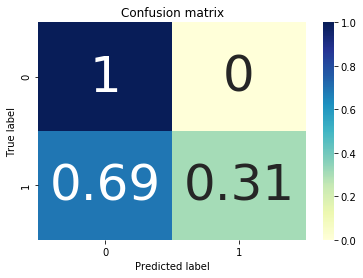

In [20]:
# Confusion Matrix function for ensemble classifier

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred = ens.predict(X_train)

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = ens.classes_, title='Confusion matrix')

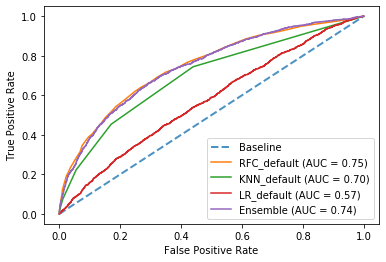

In [21]:
# ROC AUC curve

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2,
        label='Baseline', alpha=.8)

metrics.plot_roc_curve(rfc, X_test, y_test, ax=ax, name='RFC_default')
metrics.plot_roc_curve(knn, X_test, y_test, ax=ax, name='KNN_default')
metrics.plot_roc_curve(lr, X_test, y_test, ax=ax, name='LR_default')
metrics.plot_roc_curve(ens, X_test, y_test, ax=ax, name='Ensemble')

plt.show()

In [22]:
# %%time

# # hyperparameter tuning for random forest - this can be skipped, I go with default settings in the end

# criterion_options = ['gini','entropy']
# n_estimators_options = [50,75,100,125]
# max_depth_options = [None,8,10,12]
# min_samples_split_options = [2,5,10,15]
# min_samples_leaf_options = [1,2,5]

# param_grid = dict(criterion=criterion_options, n_estimators=n_estimators_options,
#                  max_depth=max_depth_options, min_samples_split=min_samples_split_options,
#                  min_samples_leaf=min_samples_leaf_options)

# X = np.array(consol_filtered.drop(['Invest','Ticker'], 1))
# y = np.array(consol_filtered['Invest'])

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# clf = RandomForestClassifier(n_jobs=-1)

# rscv = RandomizedSearchCV(clf, param_grid, scoring='roc_auc', n_jobs=-1,verbose=10)
# rscv.fit(X, y)
# rscv.best_params_

In [23]:
# %%time

# # hyperparameter tuning for k nearest neighbors - this can be skipped, I go with default settings in the end

# k_range = [150,175,200,225,250]
# weight_options = ['uniform','distance']
# leaf_size_options = [30,40,50,60]
# metric_options = ['euclidean','manhattan','chebyshev']

# param_grid = dict(n_neighbors=k_range, weights=weight_options,leaf_size=leaf_size_options,metric=metric_options)

# X = np.array(consol_filtered.drop(['Invest','Ticker'], 1))
# y = np.array(consol_filtered['Invest'])

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# clf = neighbors.KNeighborsClassifier(n_jobs=-1)

# rsearch_knn = RandomizedSearchCV(clf, param_grid, scoring='roc_auc', n_jobs=-1, verbose=10)
# rsearch_knn.fit(X, y)
# rsearch_knn.best_params_

In [24]:
# %%time

# # hyperparameter tuning for logistic regression - this can be skipped, I go with default settings in the end

# C_options = [0.01, 0.1, 1, 2, 10, 100]
# penalty_options = ['l1', 'l2']

# param_grid = dict(C=C_options, penalty=penalty_options)

# X = np.array(consol_filtered.drop(['Invest','Ticker'], 1))
# y = np.array(consol_filtered['Invest'])

# # scaler = MinMaxScaler()
# # scaler.fit(X)
# # X = scaler.transform(X)

# clf = LogisticRegression(n_jobs=-1)

# rsearch_LR = RandomizedSearchCV(clf, param_grid, scoring='roc_auc', n_jobs=-1, verbose=10)
# rsearch_LR.fit(X, y)
# rsearch_LR.best_params_